In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
daily_train = pd.read_csv('Dataset/Train/Daily-train.csv')
daily_test = pd.read_csv('Dataset/Test/Daily-test.csv')
info = pd.read_csv('Dataset/M4-info.csv')

In [3]:
daily_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V9911,V9912,V9913,V9914,V9915,V9916,V9917,V9918,V9919,V9920
0,D1,1017.10,1019.30,1017.00,1019.20,1018.70,1015.60,1018.50,1018.30,1018.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,D2,2793.70,2793.80,2803.70,2805.80,2802.30,2795.00,2806.40,2782.20,2780.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,D3,1091.30,1088.50,1085.70,1082.90,1080.10,1077.30,1074.50,1071.70,1068.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,D4,1092.00,1078.00,1064.00,1050.00,1036.00,1022.00,1008.00,1092.00,1078.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,D5,2938.63,2956.44,2964.41,2972.41,3014.97,3014.23,3024.08,3031.97,3062.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
info.head()

,M4id,category,Frequency,Horizon,SP,StartingDate
0,Y1,Macro,1,6,Yearly,01-01-79 12:00
1,Y2,Macro,1,6,Yearly,01-01-79 12:00
2,Y3,Macro,1,6,Yearly,01-01-79 12:00
3,Y4,Macro,1,6,Yearly,01-01-79 12:00
4,Y5,Macro,1,6,Yearly,01-01-79 12:00


<AxesSubplot: >

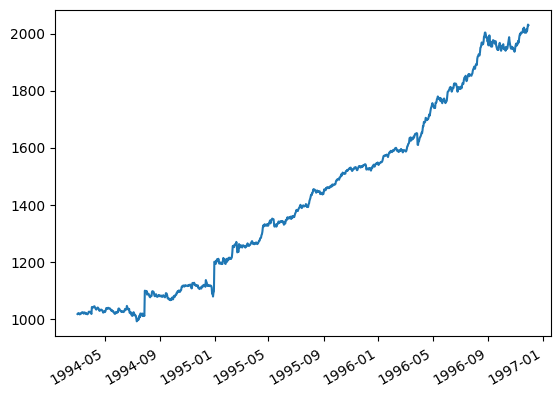

In [5]:
y_train = daily_train.iloc[0,:][1:].dropna()
series_name = daily_train.iloc[0,:][0]
start_index = info[info['M4id']==series_name]
index = pd.date_range(start_index['StartingDate'].iloc[0],periods=len(y_train),freq='D')
y_train.index = index
y_train= y_train.astype('float')
y_train.plot()

<AxesSubplot: >

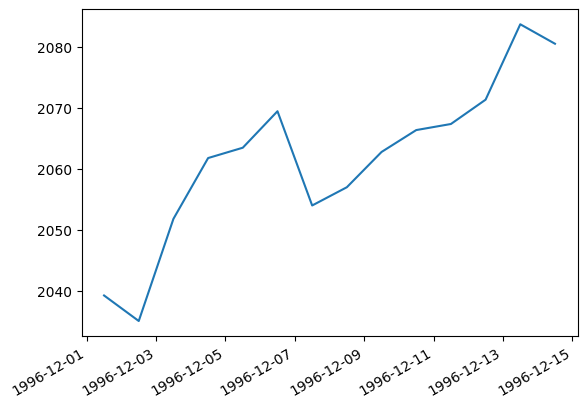

In [6]:
y_test = daily_test.iloc[0,:][1:].dropna()
start_index = y_train.index[-1]  + pd.DateOffset(1)
index = pd.date_range(start_index,periods=len(y_test),freq='D')
y_test.index = index
y_test= y_test.astype('float')
y_test.plot()

## Reduce directional change to regression

Reduce time series forecasting problem to regression. Make forecast over the forecasting horizon. Convert forecasted values to binary 1 (up), 0 (down).

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.compose import make_reduction

In [8]:
import numpy as np
from sktime.forecasting.base import ForecastingHorizon
fh = ForecastingHorizon(np.arange(1,len(y_test)+1))

In [9]:
regressor = RandomForestRegressor()

forecaster = make_reduction(regressor, window_length=15, strategy="recursive")
forecaster.fit(y_train)

RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(),
                                     window_length=15)

In [10]:
y_pred = forecaster.predict(fh=fh)


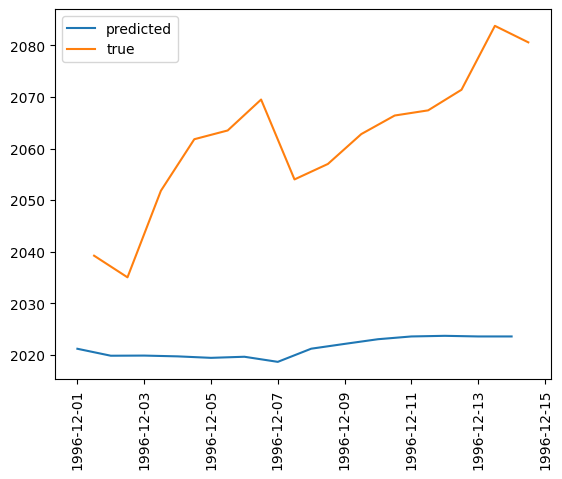

In [11]:
plt.plot(y_pred, label='predicted')
plt.plot(y_test, label='true')
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [12]:
concat_test_train = pd.concat([y_train[-2:-1],y_test])
true_dc = concat_test_train.shift(-1) > concat_test_train
true_dc = true_dc[0:-1]
true_dc[true_dc==True] =1
true_dc[true_dc==False] =0

In [13]:
concat_test_train = pd.concat([y_train[-2:-1],y_pred])
predict_dc = concat_test_train.shift(-1) > concat_test_train
predict_dc = predict_dc[0:-1]
predict_dc[predict_dc == True] =1
predict_dc[predict_dc == False] =0

In [14]:
predict_dc.index[0:-1]

DatetimeIndex(['1996-11-29 12:00:00', '1996-12-01 00:00:00',
               '1996-12-02 00:00:00', '1996-12-03 00:00:00',
               '1996-12-04 00:00:00', '1996-12-05 00:00:00',
               '1996-12-06 00:00:00', '1996-12-07 00:00:00',
               '1996-12-08 00:00:00', '1996-12-09 00:00:00',
               '1996-12-10 00:00:00', '1996-12-11 00:00:00',
               '1996-12-12 00:00:00'],
              dtype='datetime64[ns]', freq=None)

In [15]:
predict_dc

1996-11-29 12:00:00    0
1996-12-01 00:00:00    0
1996-12-02 00:00:00    1
1996-12-03 00:00:00    0
1996-12-04 00:00:00    0
1996-12-05 00:00:00    1
1996-12-06 00:00:00    0
1996-12-07 00:00:00    1
1996-12-08 00:00:00    1
1996-12-09 00:00:00    1
1996-12-10 00:00:00    1
1996-12-11 00:00:00    1
1996-12-12 00:00:00    0
1996-12-13 00:00:00    0
dtype: object

In [39]:
df = pd.DataFrame.from_dict({'true': predict_dc.values, 'predict': predict_dc.values})
df.index = predict_dc.index

In [40]:
df

,true,predict
1996-11-29 12:00:00,0,0
1996-12-01 00:00:00,0,0
1996-12-02 00:00:00,1,1
1996-12-03 00:00:00,0,0
1996-12-04 00:00:00,0,0
1996-12-05 00:00:00,1,1
1996-12-06 00:00:00,0,0
1996-12-07 00:00:00,1,1
1996-12-08 00:00:00,1,1
1996-12-09 00:00:00,1,1


In [34]:
predict_dc.values

array([0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0], dtype=object)

evaluation

In [16]:
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc

In [17]:
accuracy_score(true_dc.tolist(), predict_dc.tolist())

0.7142857142857143

In [18]:
f1_score(true_dc.tolist(), predict_dc.tolist())

0.7777777777777778

In [19]:
fpr, tpr, thresholds = roc_curve(true_dc.tolist(), predict_dc.tolist(), pos_label=1)
auc(fpr,tpr)

0.8181818181818181

## Reduce directional change to tabular classification


Use sktime's _`sliding_window_transform` function to convert the time series to tabular format. Convert labels to binary 1 (up), 0 (down). Train supervised classfication algorithms on the transformed dataset.

In [20]:
window_length=100

In [21]:
from sktime.forecasting.compose._reduce import _sliding_window_transform

In [22]:
fh=ForecastingHorizon([1])
y_tmp,x_dc = _sliding_window_transform(y_train,window_length=window_length,fh=fh)
y_dc = np.zeros(len(y_tmp))
y_tmp = y_tmp.reshape(x_dc[:,-1].shape)
y_mask = (x_dc[:,-1] > y_tmp) #up observations
y_dc[y_mask]=1

supervised classification

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
cls = RandomForestClassifier()
cls.fit(X=x_dc, y=y_dc)

RandomForestClassifier()

concatenate the train and testing sets. Reduce to supervised classification problem to produce one step ahead directional forecasts.

The sliding window uses the previous observatrions in the training and test set to produce a one step ahead forecast.

In [25]:
y_test_concat = pd.concat([y_train[-window_length-1:-1],y_test])

In [26]:
y_tmp_test,x_dc_test = _sliding_window_transform(y_test_concat,window_length=window_length,fh=fh)
y_dc_test = np.zeros(len(y_tmp_test))
y_tmp_test = y_tmp_test.reshape(x_dc_test[:,-1].shape)
y_mask = (x_dc_test[:,-1] > y_tmp_test) #up observations
y_dc_test[y_mask]=1

In [27]:
y_dc_predict = cls.predict(x_dc_test)

In [28]:
y_dc_test

array([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.])

In [29]:
y_dc_predict

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])